# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

import seaborn as sns

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [3]:
train_df = pd.read_csv('Bikeshare_train.csv').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv('Bikeshare_test.csv').drop('Unnamed: 0', axis=1)
train_df.head(5)

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [4]:
train_df.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,2.561934,6.640483,0.033233,2.854985,0.670695,1.389728,17.018127,19.543807,63.385776,0.190833,4598.447130
std,1.094726,3.353974,0.179515,2.048680,0.470672,0.546962,11.192515,9.930991,14.334789,0.078240,1935.319338
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,7.500000,11.000000,52.702900,0.133083,3370.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000
75%,4.000000,9.500000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.500000,0.235380,5981.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,38.000000,39.000000,97.250000,0.421642,8714.000000


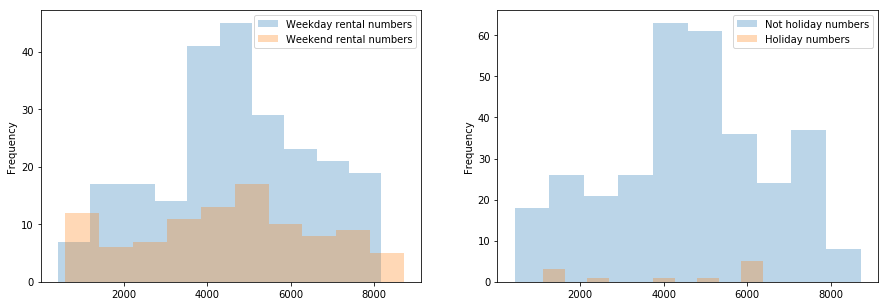

In [5]:
#useful variables for later on
weekend = [0,6]
rain_or_snow = [0,6]

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()

def plot_relevant_question(dataframe, ax, labels_to_use, criteria_label, criteria, boolean_query=True):
    df = dataframe.copy()
    
    if boolean_query:
        df['column_of_interest'] = df[criteria_label].isin(criteria)
        for g, group in df.groupby('column_of_interest'):
            group['count'].plot(kind='hist', ax=ax, alpha=0.3, label = labels_to_use[g])
        ax.legend(loc='best')
        
    else:
        for i, (g, group) in enumerate(df.groupby(criteria_label)):
            group['count'].plot(kind='hist', ax=ax[i], bins=10, alpha=0.3, label = labels_to_use[i])
            ax[i].set_title(labels_to_use[i])
            ax[i].set_xlim(0,9000)
plot_relevant_question(train_df, ax[0], ['Weekday rental numbers', 'Weekend rental numbers'], 'day_of_week', weekend)
plot_relevant_question(train_df, ax[1], ['Not holiday numbers', 'Holiday numbers'], 'holiday', [1.0])

plt.show()

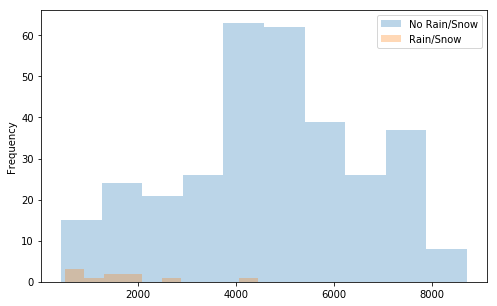

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_relevant_question(train_df, ax, ['No Rain/Snow', 'Rain/Snow'], 'weather', [3,4])
plt.show()

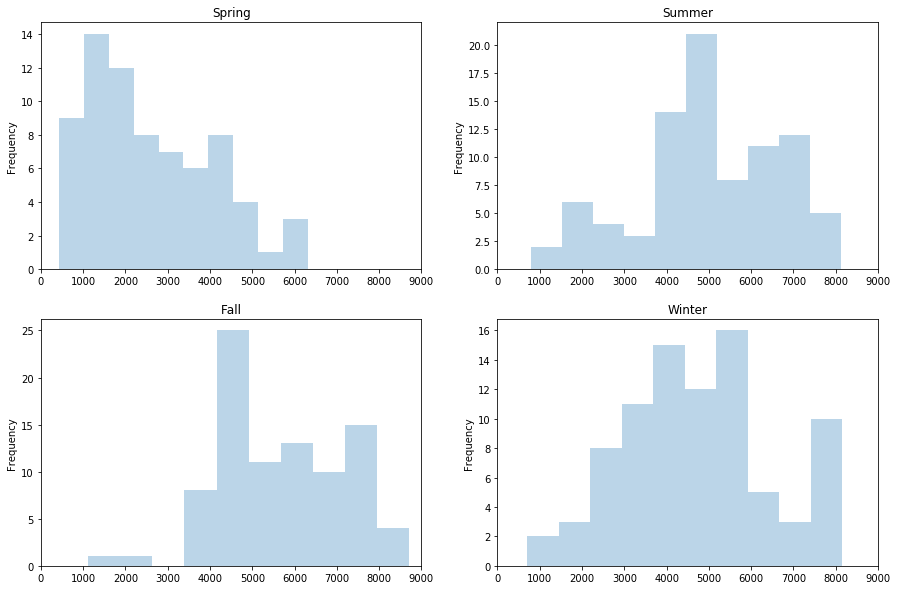

In [7]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()
plot_relevant_question(train_df, ax, ['Spring', 'Summer', 'Fall', 'Winter'], 'season', None, False)

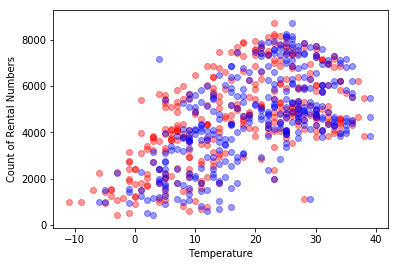

In [8]:
plt.ylabel('Count of Rental Numbers')
plt.xlabel('Temperature')
plt.scatter(train_df['temp'].values, train_df['count'].values, alpha=0.4 , c='r')
plt.scatter(train_df['atemp'].values, train_df['count'].values, alpha=0.4, c='b')
plt.show()

C:\Users\ashwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ashwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


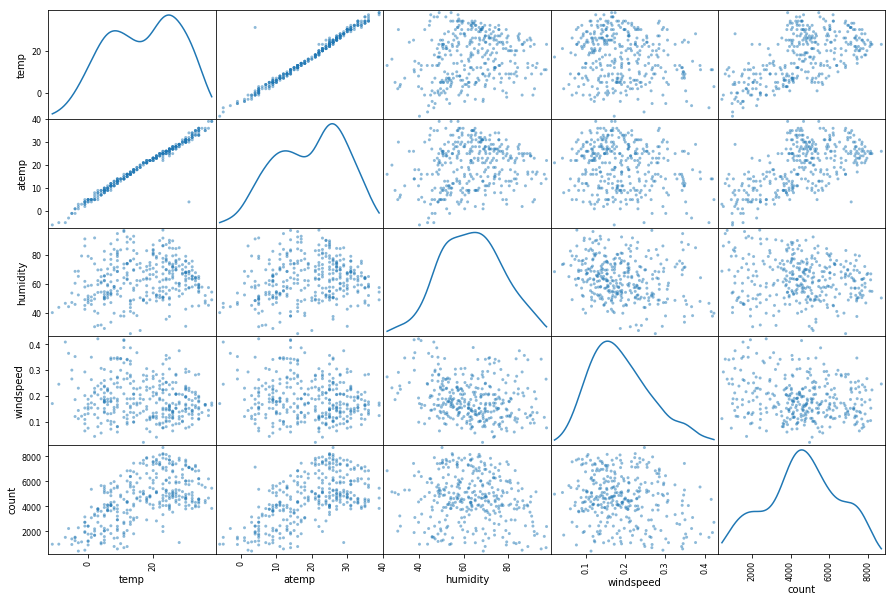

In [9]:
from pandas.tools.plotting import scatter_matrix
fig, ax = plt.subplots(1,1, figsize=(15,10))
axes = scatter_matrix(train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']], alpha=0.5, diagonal='kde', ax=ax)
plt.show()

your answers here:

Q: How does the number of bike rentals vary between weekdays and weekends?

A: The distributions seem comparable. There is a smaller number of samples from the weekends and thus outliers carry more weight in the distribution.

<hr />
Q: How about bike rentals on holidays?

A: Lower numbers on holidays. More rentals on not-holidays. Possible large number of customers are commuters.

<hr />
Q: What effect does the season have on the bike rentals on a given day?

A: Season variable looks strange. Possible miss-ordering of value labels? Spring has a high frequency of low numbers of rentals, Fall a high frequency of high number of rentals and Winter and Summer seem to fall in the middle.

<hr />
Q: Is the number of bike rentals lower than average when there is rain or snow?

A: Substantially. Yes

<hr />
How does temperature effect bike rentals?

A: There could be a positive correlation between temp and number of rentals. This should be investigated further.

<hr />
Q: Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?

A: Temp and count appear to have some sort of dependence.

<hr />

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [10]:
categorical_columns = ['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'day_of_week', 'weather']
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']

In [11]:
# your code here
train_df = pd.get_dummies(train_df, columns=categorical_columns_g2cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_columns_g2cols, drop_first=True)
test_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
0,0.0,1.0,2.0,6.0,56.2083,0.194037,3830.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,1.0,1.0,3.0,65.2917,0.350133,2114.0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,0.0,1.0,36.0,37.0,56.8333,0.149883,915.0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,1.0,8.0,12.0,49.0833,0.268033,4322.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.0,28.0,29.0,69.7083,0.215171,6591.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean)/std

In [13]:
train_df.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
count,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.033233,0.670695,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130,0.259819,0.265861,0.256798,...,0.093656,0.066465,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.329305,0.030211
std,0.179515,0.470672,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338,0.439199,0.442459,0.437528,...,0.291790,0.249471,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.171428
min,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Q: Why can't they be directly used as predictors?

A: categorical predictors make no sense on a quanitative scale.

<hr />
Q: Why is it okay to not have a binary column for the  Kj -th category?

A: N-1 categorical variables can be used to encode N options (e.g. Jan-Nov == 0 then the last month must be Dec).

<hr />
Q: Why shouldn't we include the test set observations in computing the mean and SD?

A: We would be using information twice. Big NO! We never want to 'see' the data that we are testing the model on.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [13]:
# your code here
X = sm.add_constant(train_df.drop('count', axis=1))
X_test = sm.add_constant(test_df.drop('count', axis=1))
y = train_df['count'].values.reshape(-1,1)

model = OLS(endog=y, exog=X)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_test)

print('train r2 = ', r2_score(train_df['count'], y_hat_train))
print('test r2 = ', r2_score(test_df['count'], y_hat_test))

train r2 =  0.576128178313
test r2 =  0.249342111465


In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Sun, 15 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        10:58:06   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3681.7765    433.655      8.490      0.000    2828.419    4535.134
holiday          -284.3563    398.982     -0.713      0.477   -1069.483     500.770
workingday        308.1531    165.413      1.863      0.063     -17.351     633.657
temp              925.7338    474.536      1.951      0.052      -8.070    1859.538
atemp             312.4341    429.987      0.727      0.468    -533.705    1158.573
humidity         -548.4929    113.200     -4.845      0.000    -771.251    -325.735
windspeed        -255.1226     80.766     -3.159      0.002    -414.057     -96.189
season_2.0        898.8290    487.802      1.843      0.066     -61.079    1858.737
season_3.0       1032.8816    567.827      1.819      0.070     -84.503    2150.266
season_4.0       1226.1865    506.763      2.420      0.016     228.966    2223.407
month_2.0          88.9401    397.048      0.224      0.823    -692.381     870.262
month_3.0         239.1809    446.873      0.535      0.593    -640.188    1118.549
month_4.0         333.3491    675.444      0.494      0.622    -995.806    1662.504
month_5.0         -65.8125    726.311     -0.091      0.928   -1495.065    1363.440
month_6.0        -792.2629    749.803     -1.057      0.292   -2267.744     683.218
month_7.0       -1279.9870    816.047     -1.569      0.118   -2885.824     325.850
month_8.0        -776.4755    794.782     -0.977      0.329   -2340.467     787.516
month_9.0         405.1446    694.714      0.583      0.560    -961.931    1772.220
month_10.0        486.2509    651.713      0.746      0.456    -796.206    1768.708
month_11.0        112.6816    621.610      0.181      0.856   -1110.538    1335.902
month_12.0       -118.8358    505.353     -0.235      0.814   -1113.282     875.611
day_of_week_1.0  -123.7515    170.981     -0.724      0.470    -460.212     212.709
day_of_week_2.0  -195.2859    203.703     -0.959      0.338    -596.137     205.565
day_of_week_3.0   170.5113    213.789      0.798      0.426    -250.187     591.210
day_of_week_4.0    61.2560    206.213      0.297      0.767    -344.536     467.048
day_of_week_5.0   111.0669    198.877      0.558      0.577    -280.288     502.422
day_of_week_6.0   465.1450    269.154      1.728      0.085     -64.504     994.794
weather_2.0       -16.5666    210.139     -0.079      0.937    -430.083     396.949
weather_3.0     -1581.9783    529.223     -2.989      0.003   -2623.396    -540.560
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     1.92e+15


In [15]:
result.pvalues[((result.pvalues < 0.05) & (result.params > 0))]

const         9.368885e-16
season_4.0    1.612408e-02
dtype: float64

your answers here

Q: Which among the predictors have a positive correlation with the number of bike rentals?

A: [const, season_4.0]

<hr />

Q: Does the day of a week have a relationship with bike rentals?

A: Apart from Sunday, there does not appear to be a relationship between day of week and rental numbers. Sunday is not significant but this could be worth investigating.

<hr />
Q: Does the month influence the bike rentals?

A: There appears to be no evidence for this.

<hr />
Q: What effect does a holiday have on bike rentals?

A: There is no evidence for an effect from holiday

<hr />
Q: Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.

A: No. temp and atemp are highly colinear and thus model results are misleading. From plot in 1a we see these data are similarily distributed.

<hr />

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

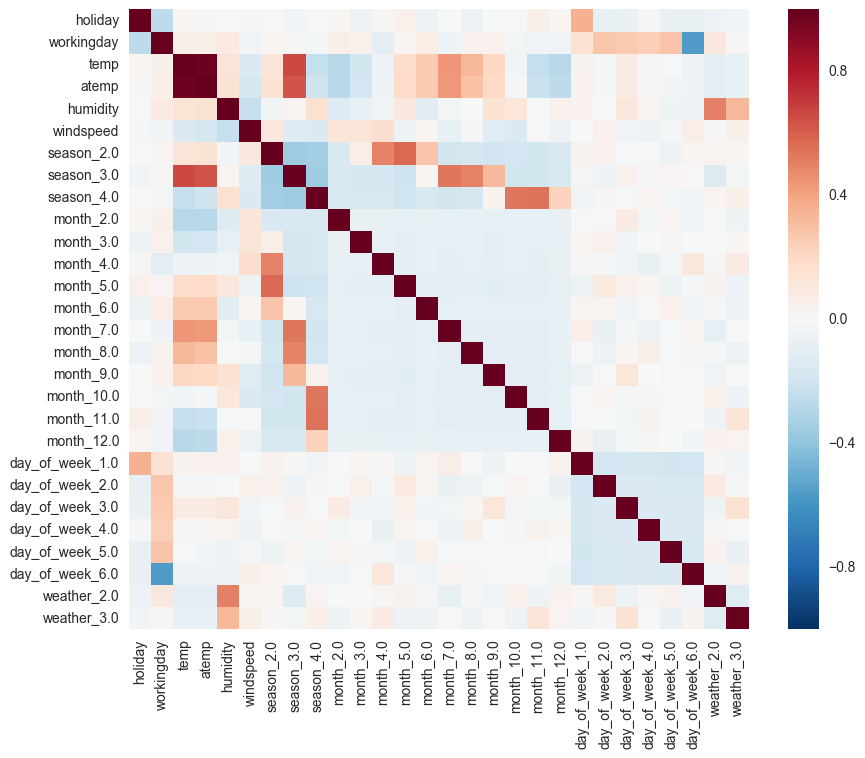

In [16]:
# your code here
interesting_columns = train_df.drop('count', axis=1).columns
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(np.corrcoef(train_df.drop('count', axis=1).T), ax=ax)
ax.set_xticklabels(interesting_columns, rotation='vertical')
ax.set_yticklabels(interesting_columns[::-1], rotation='horizontal')
plt.show()

There are a number of highly co-linear predictors (temp and atemp, humidity and weather_2, season_4 and months_10 and 11 etc). These are examples of predictors describing the same phenomenon.

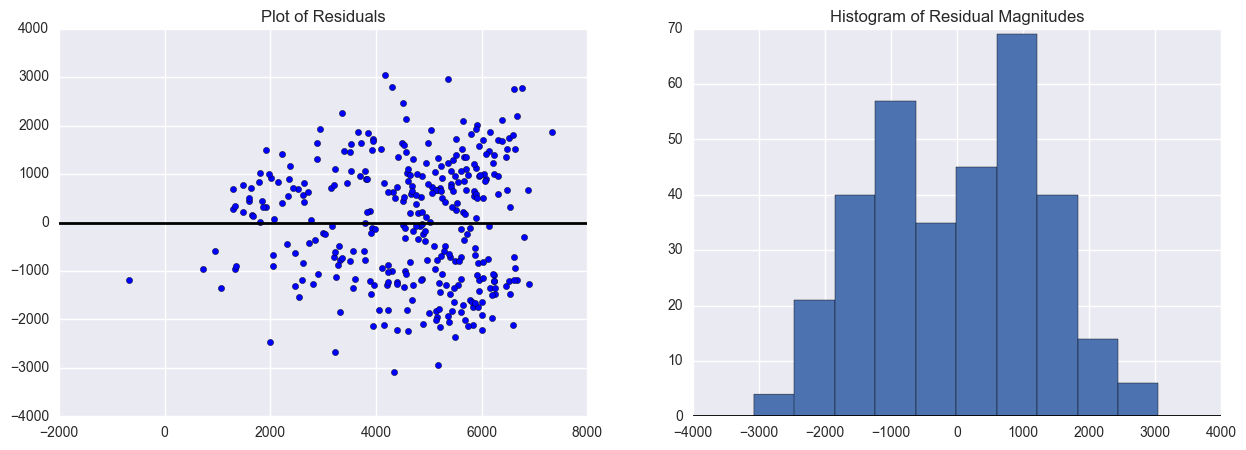

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, y_hat_train - y[:,0])
axes[0].axhline(0, c='black', lw=2)

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(y_hat_train - y[:,0])
axes[1].axhline(0, c='black', lw=2)
plt.show()

Assumption of heteroskadicity seems violated. Assumption of normally distributed residuals seems violated.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [18]:
# your code here
def step_forwards_backwards(df, response_var, direction='forward'):
    
    assert direction in ['forward', 'backward']
    
    y = df[response_var].values.reshape(-1,1)

    predictors = set(train_df.drop('count', axis=1).columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = df.shape[0]
    best_bic = np.inf
    
    best_bics = []
    best_models = []
    
    if direction == 'forward':
        X = np.ones(n).reshape(-1,1)
        X = np.concatenate([X, train_df[list(selected_predictors)].values], axis=1)
        while (True):
            
            possible_bic_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            for predictor in possible_predictors:
                
                x_temp = np.concatenate([X, train_df[predictor].values.reshape(-1,1)], axis=1)
                model = OLS(endog=y, exog=x_temp).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
                
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            
            best_bic = np.min(possible_bic_scores)
            best_bics.append(best_bic)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, train_df[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))

    else:

        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break

            for predictor in possible_predictors:
                X = np.concatenate([np.ones(n).reshape(-1,1), train_df[list(selected_predictors - set([predictor]))].values], axis=1)
                model = OLS(endog=y, exog=X).fit()
                bic = model.bic
                possible_bic_scores.append(bic)

            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix] 

            best_bic = possible_bic_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_bics.append(best_bic)
            best_models.append(list(selected_predictors))
            
    index_of_best_bic = np.argmin(best_bics)

    return best_models[index_of_best_bic]

In [19]:
predictors_forward = step_forwards_backwards(train_df, 'count', direction='forward')
predictors_forward

['weather_3.0',
 'windspeed',
 'atemp',
 'season_2.0',
 'humidity',
 'season_4.0',
 'month_9.0']

In [20]:
predictors_backward = step_forwards_backwards(train_df, 'count', direction='backward')
predictors_backward

['month_7.0',
 'season_3.0',
 'season_2.0',
 'humidity',
 'month_8.0',
 'season_4.0',
 'weather_3.0',
 'windspeed',
 'month_6.0',
 'temp']

In [21]:
# your code here
X = sm.add_constant(train_df[predictors_forward])
X_test = sm.add_constant(test_df[predictors_forward])
y = train_df['count'].values.reshape(-1,1)

model = OLS(endog=y, exog=X)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_test)

print('train r2 = ', r2_score(train_df['count'], y_hat_train))
print('test r2 = ', r2_score(test_df['count'], y_hat_test))

train r2 =  0.532513398328
test r2 =  0.27579228429


In [22]:
# your code here
X = sm.add_constant(train_df[predictors_backward])
X_test = sm.add_constant(test_df[predictors_backward])
y = train_df['count'].values.reshape(-1,1)

model = OLS(endog=y, exog=X)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_test)

print('train r2 = ', r2_score(train_df['count'], y_hat_train))
print('test r2 = ', r2_score(test_df['count'], y_hat_test))

train r2 =  0.556442132115
test r2 =  0.270481135658


## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [23]:
# your code here
# import sklearn.cross_validation
from sklearn.cross_validation import KFold

n = train_df.shape[0]
scores = []

for f_train, f_test in KFold(n, n_folds=10, shuffle=False, random_state=11):

    mini_train = train_df.iloc[f_train]
    mini_test = train_df.iloc[f_test]
    score = []
    
    for model in [train_df.drop('count', axis=1).columns, list(predictors_backward), list(predictors_forward)]:
        
        X = sm.add_constant(mini_train[model])
        X_test = sm.add_constant(mini_test[model], has_constant='add') #small number of training examples
        
        y = mini_train['count'].values.reshape(-1,1)
        y_test = mini_test['count'].values.reshape(-1,1)

        model = OLS(endog=y, exog=X)
        result = model.fit()

        y_hat_train = result.predict()
        y_hat_test = result.predict(exog=X_test)
        
        score.append(r2_score(y_test, y_hat_test))
                     
    scores.append(score)
    
scores = np.array(scores)
np.mean(scores, axis=0)

array([ 0.34257855,  0.46033274,  0.4402681 ])

Notice that the cross validation (CV) scores are substantially higher than the scores on the test set. However, they are not as high as the score achieved on the train. This is fishy. While the models that are selected do agree, CV should be giving a good approximation to the test (unseen) data score. This is not the case as the entire dataset was used in the previous step to select the model predictors and thus we have used the data twice here.